# Amplitude Source Location (ASL) - Recreating Jacob's notebook with flovopy

## 1. Imports

[INV] Networks: 1  Stations: 5  Channels: 18
Dome (assumed source) = {'lat': 14.475, 'lon': -90.88}
[GRID] 361x361 nodes (130321 total)  spacing=50.0 m  [no mask]


/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Grid


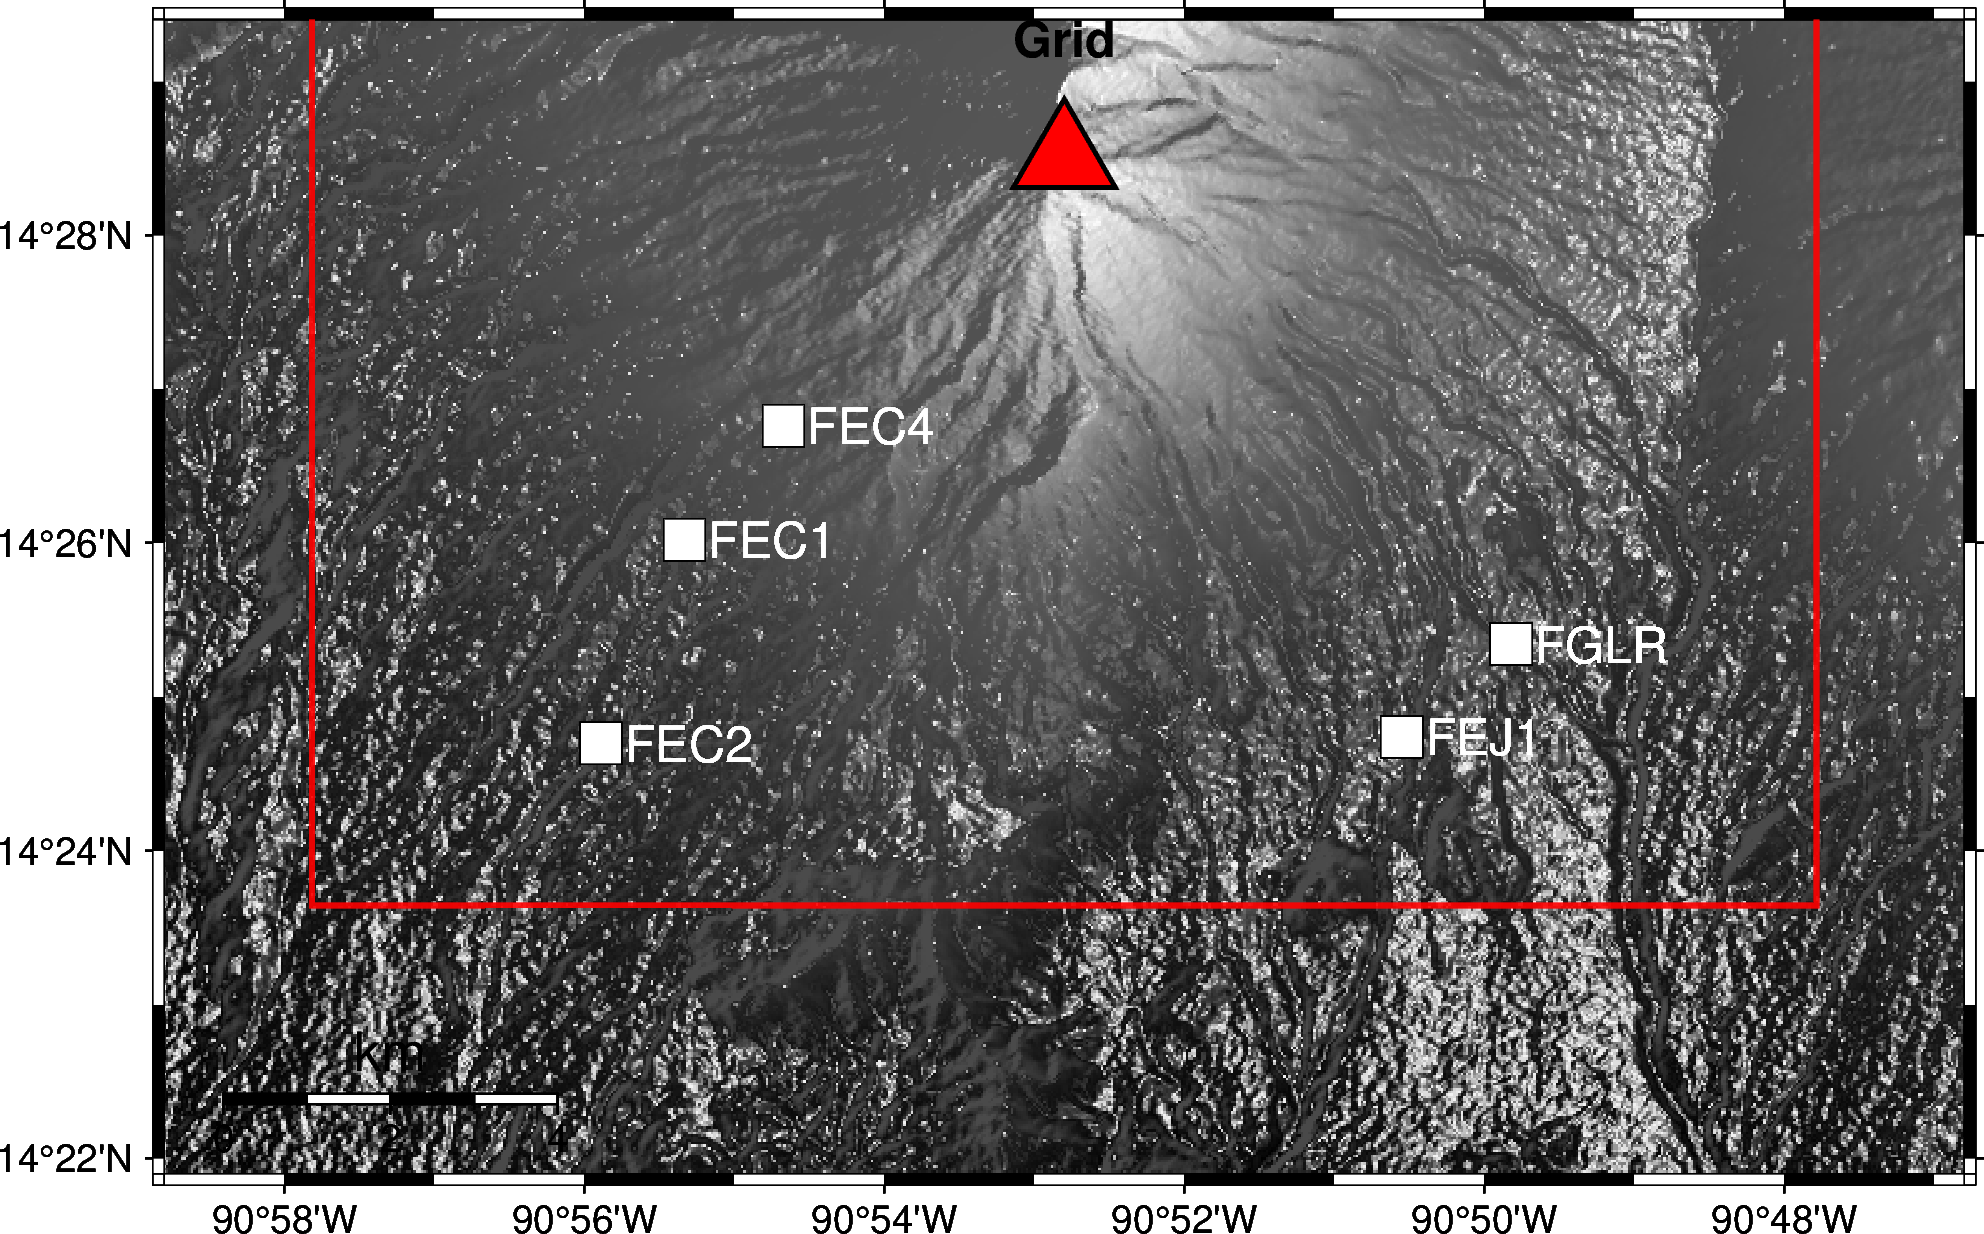

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory, UTCDateTime
from importlib import reload
from flovopy.asl.wrappers import run_single_event, find_event_files, run_all_events
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig, tweak_config

# Core ASL + utilities
from flovopy.asl.asl import ASL
from flovopy.asl.wrappers import asl_sausage
from flovopy.asl.grid import Grid, make_grid
from flovopy.asl.distances import compute_or_load_distances, distances_signature
from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams
from flovopy.asl.misfit import StdOverMeanMisfit, R2DistanceMisfit, LinearizedDecayMisfit
from flovopy.asl.map import topo_map

# --- Diagnostics / comparisons ---
from flovopy.asl.compare import extract_asl_diagnostics, compare_asl_sources

# --- Simulation helpers ---
from flovopy.asl.simulate import simulate_SAM, plot_SAM, synthetic_source_from_grid

# -------------------------- Config --------------------------
# directories
HOME = Path.home()
DATA_DIR = HOME / 'Dropbox' / 'BRIEFCASE'/ 'SSADenver'  /'Jacob'

# master files
INVENTORY_XML   = DATA_DIR / "6Q.xml"

REGION_DEFAULT = [-90.98, -90.78, 14.365, 14.49]
DEM_DEFAULT = None

# other parameters
DIST_MODE = "2d"

# Inventory of Montserrat stations
INV     = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

MAT_FILE = DATA_DIR / "outputfromReadMapData.mat"
MSEED_DIR = DATA_DIR / "ClipMSEED"                # directory containing MiniSEED


'''
SRTM_ASC_GZ = DATA_DIR / "srtm_18_10.asc.gz"      # optional background
SRTM_CELL = 0.00083333333333333
SRTM_XLL  = -95.0
SRTM_YLL  = 10.0

stations = ['FEJ1', 'FEC1', 'FEC2', 'FEC4']       # order must match sta rows

# Seismo params
sps = 200
lc, hc = 1.0, 99.0                                # bandpass (Hz)
pre_filt = (0.5, 0.8, 90.0, 100.0)                # for remove_response
beta = 1250.0                                     # m/s, assumed wave speed
m_slope = -1.0                                    # -1 body, -0.5 surface

winlength_seconds = 10
plot_limits_sec = (7500, 10000)
t_start_sec = 8000
t_end_sec   = 9200

# Local-grid -> UTM offsets (apply BEFORE transforming to geographic)
UTM_E_OFFSET = 715_901.84
UTM_N_OFFSET = 1_584_182.68

# CRS (example: UTM zone 15N; change if needed)
CRS_UTM = CRS.from_epsg(32615)
CRS_WGS84 = CRS.from_epsg(4326)
TO_WGS84 = Transformer.from_crs(CRS_UTM, CRS_WGS84, always_xy=True)

'''

# Montserrat constants
dome_location = {'lat': 14.475, 'lon':-90.88}
print("Dome (assumed source) =", dome_location)

# define grid size and spacing
GRID_SIZE_LAT_M = 18_000   
GRID_SIZE_LON_M = 18_000  
NODE_SPACING_M  = 50       


gridobj = make_grid(
    center_lat=dome_location["lat"],
    center_lon=dome_location["lon"],
    node_spacing_m=NODE_SPACING_M,
    grid_size_lat_m=GRID_SIZE_LAT_M,
    grid_size_lon_m=GRID_SIZE_LON_M,
    dem=None,
)
print(gridobj)

# Parameters to pass for making pygmt topo maps
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
    "topo_color": False,
}

gridobj.plot(show=True, min_display_spacing=300, scale=2.0, topo_map_kwargs=topo_kw);


Running: /opt/anaconda3/envs/flovopy_plus/bin/python /Users/glennthompson/Developer/flovopy/flovopy/asl/find_channels.py --region -90.98 -90.78 14.365 14.49 --earth-relief 01s --outdir /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/Jacob/jacob_channels --top-n 30 --min-len-m 200.0 --prep
[PyGMT] Saved Earth Relief 01s GeoTIFF → /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/Jacob/jacob_channels/00_earth_relief.tif
Normalizing DEM for WBT…
Normalized DEM: /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/Jacob/jacob_channels/01_dem_norm.tif  exists=True  size=686402
[CRS] Using UTM EPSG:32615
[GDAL] gdalwarp -overwrite -t_srs EPSG:32615 -tr 10.0 10.0 -dstnodata -32768.0 -r bilinear -multi -wo NUM_THREADS=ALL_CPUS -co COMPRESS=LZW -co PREDICTOR=1 "/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/Jacob/jacob_channels/01_dem_norm.tif" "/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/Jacob/jacob_channels/03_dem_utm.tif"
Creating output file that is 2218P x 1452L.
Using internal nodata v

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Grid


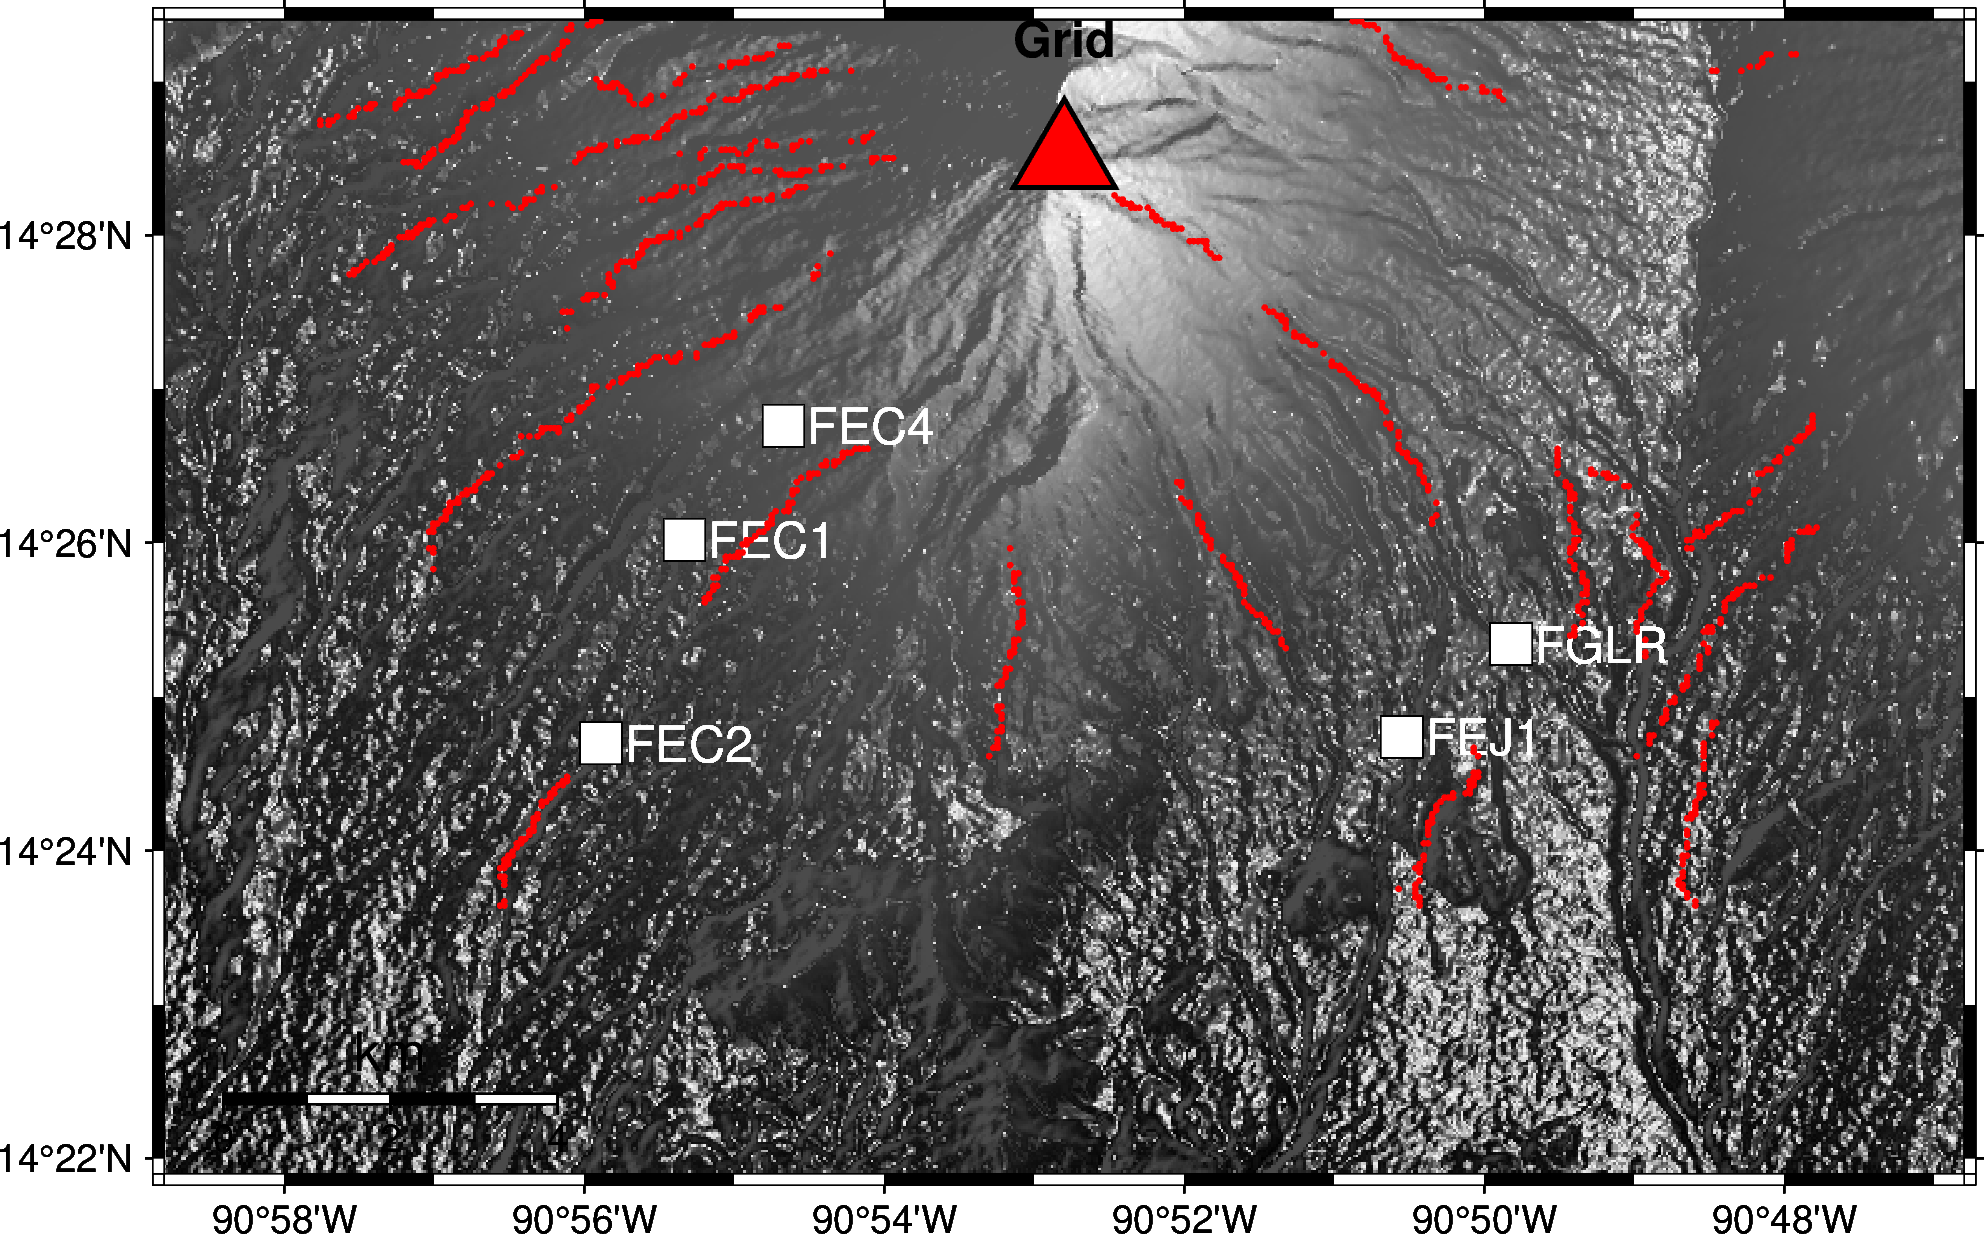

In [ ]:


from flovopy.asl.find_channels import run_find_channels,  nodegrid_from_channels_dir
# Your region and output directory

outdir = DATA_DIR / "jacob_channels"

# 1) Run the pipeline (same as your CLI), optionally add flags like '--prep'
run_find_channels(
    region=REGION_DEFAULT,
    outdir=outdir,
    earth_relief="01s",
    extra_args=["--prep"]  # add/remove flags as you like
)

# 2) Load the channel points into a NodeGrid (in-memory)
ng = nodegrid_from_channels_dir(outdir, approx_spacing_m=20.0)


/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Grid


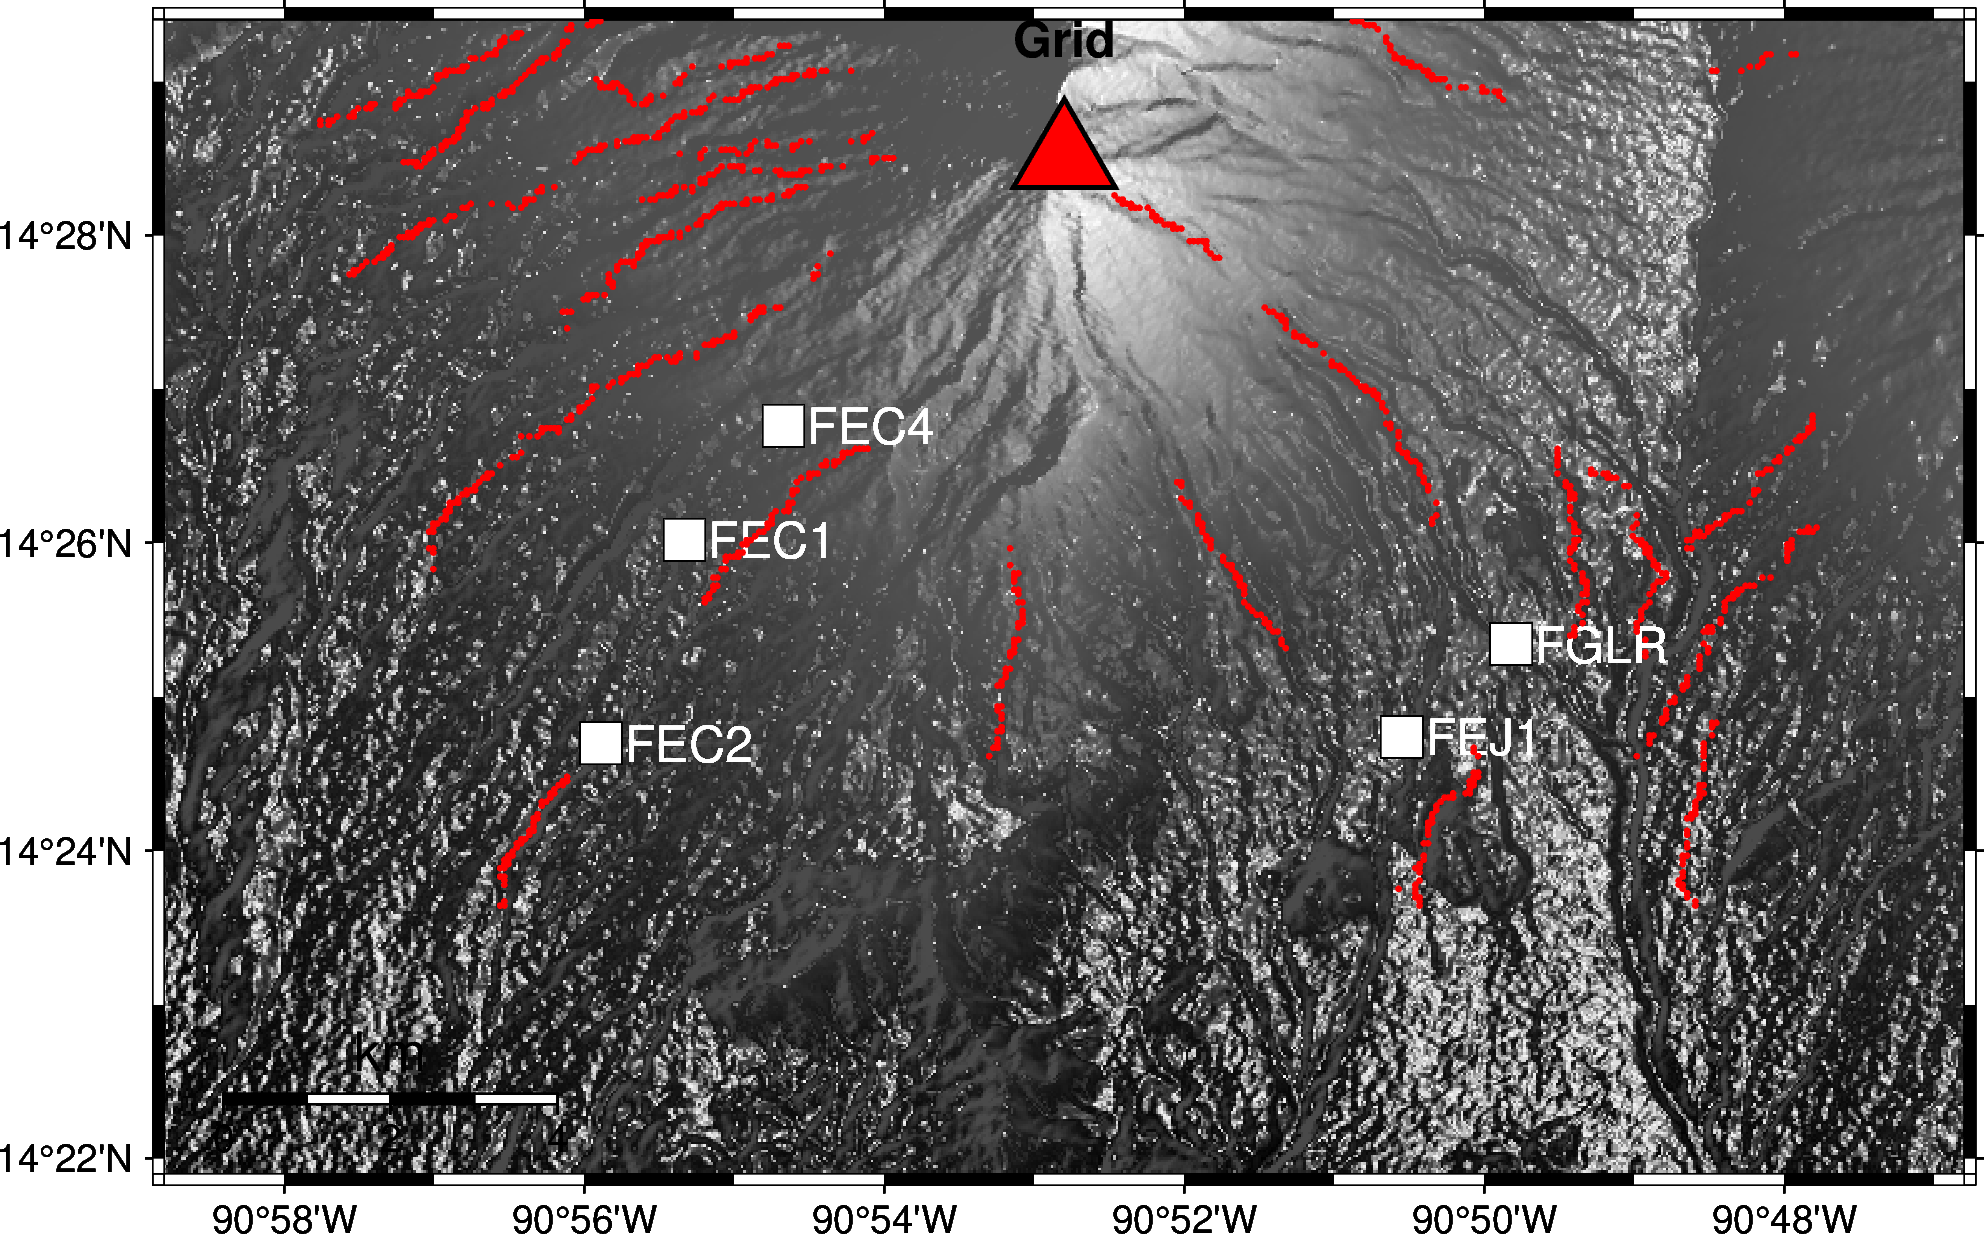

In [7]:

# Mask based on NodeGrid → nearest horizontal neighbors in the Grid
channels_grid, mask2d, matches = ng.mask_grid_with_nodes(
    gridobj,
    k=10,
    max_m=30.0,
    flatten_copy=True,
    mask_name="channels_only",
    return_matches=True,
)


# If your Grid supports plotting masks:
channels_grid.plot(
    topo_map_kwargs=topo_kw,
    symbol="c", scale=2.0, fill="red", force_all_nodes=True, show=True,
);

## 2. Load seismic data

In [ ]:
from obspy import Stream, read
MSEED_DIR = DATA_DIR / "ClipMSEED"   
st = Stream()
for f in MSEED_DIR.glob('*.mseed'):
    if 'HHZ' in str(f):
        print(f)
        tr = read(f)[0]
        st.append(tr)
print(st)
st.plot();


## 3. Remove instrument response

In [ ]:
st.detrend('linear')
pre_filt = [0.5, 1.0, 80.0, 95.00]
st.remove_response(pre_filt=pre_filt, inventory=INV, output='VEL')
st.plot();


In [ ]:
'''
st_downsampled = st.copy()
st_downsampled.decimate(factor=4)

st_downsampled.spectrogram(dbscale=False)
'''

# Configure

In [ ]:
window_seconds = 10 
beta = 1.25
t_start_sec = 8000
t_end_sec   = 9200
event_st = st.copy()
t0 = event_st[0].stats.starttime
event_st.trim(starttime = t0+t_start_sec, endtime=t0+t_end_sec)
peakf = 5.0
Q = 30.0

cfg = ASLConfig(
    inventory=INV, 
    output_base=DATA_DIR / "asl_results", 
    gridobj=gridobj,
    wave_kind='surface',
    speed=beta,
    peakf = peakf,
    Q = Q,
    window_seconds=window_seconds,
    global_cache='/tmp',
    station_correction_dataframe=None,
    dist_mode="2d", 
    misfit_engine="lin",
    min_stations=4,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=True,
)
cfg.build()



# Locate

In [ ]:
mseed_file = '/tmp/jacob_event.mseed'
event_st.write(mseed_file, format='MSEED')
result = run_single_event(
    mseed_file=mseed_file,
    cfg=cfg,
    station_gains_df=None,
    switch_event_ctag = True,
    topo_kw=topo_kw,
    mseed_units='m/s', # default units for miniseed files being used - probably "Counts" or "m/s"        
    reduce_time=True,
    refine_sector=False,
    debug=True,
)